<h1><center> Lab 5: Data Science, Algorithmic Fairness and Networks </center></h1>

This week (Week 5) we are learning about ethical aspects of data science and about conceptual tools to think through ethical questions in this field. Several examples of bias and algorithmic discrimination in data science and Artificial Intelligence are discussed (e.g., discrimination in Amazon Prime and COMPAS). Several metrics of fairness are also discussed (e.g., Demographic Parity and Equalised Odds).

In this Lab, we will learn how to deal with bias and discrimination in practice. We will exercise how to apply new (Python) libraries to identify and mitigate bias in machine learning classification. This is an area known as Algorithmic Fairness.

We suggest that you watch, before this Lab, the 7-min [video](https://canvas.uva.nl/courses/45979/pages/lab-5-preparation-video-fairness-metrics?module_item_id=2187867) we added in *Canvas > Modules > Week 5: Lab 5 preparation - Video fairness metrics*, so that you have an overview of fairness metrics used in the field.

This notebook will also be an opportunity to exercise the contents of the previous weeks (Week 3) on **Decision Trees** and **Model Validation**, both to be evaluated in Quiz 3 — and useful in Assignment 2.

We will use [Fairlearn](https://fairlearn.org), an open-source, community-driven project to help data scientists improve fairness of AI systems. **If you do not have fairlearn installed, you can uncomment and use the line below.**

In [1]:
!pip install fairlearn

<h3><center> Fairlearn </center></h3>

The exercise we will work on in this lab is based on the examples provided in the [Fairlearn documentation](https://fairlearn.org/v0.7.0/quickstart.html). Specifically, <span style="color:red">this example is a slightly adapted version from this</span> [notebook](https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb). If you are interested in knowing more about the problem analyzed here, you can also check this [white paper](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf) (this is not necessary to complete the Lab, though, and note that the white paper uses a different dataset that cannot be released due to data privacy issues).

1. First we will load and apply a typical classification algorithm to a [banking loan UCI dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). We will cover the application of Decision Trees.
2. We will then use metrics implemented in *Fairlearn* to evaluate how fair is our baseline model.
3. Finally, we will apply mitigation stragies to try to make our classifier less biased. This part is optional for Lab 5 — we will explore this further in the lectures of Week 6.

In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference,
    equalized_odds_difference)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

The Default of Credit Card Clients Taiwan Data Set dataset contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features (SEX, EDUCATION, MARRIAGE, AGE), the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. A model trained on this data could be used, in part, to determine whether a client is eligible for another loan or a credit increase.

Dataset columns / predictors:

* `LIMIT_BAL`: credit card limit, i.e., amount of given credit; will be replaced by a synthetic feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the client defaulted the following month (1 means default; 0 means no-default (good outcome))

In [3]:
# Load the data: UCI Default of credit card clients Data Set 
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

# if you have any issues importing the online file through the link above, please import 
# the file "default_of_credit_card_clients.xls" you can find in Canvas, Modules > Week 5
#dataset = pd.read_excel("default_of_credit_card_clients.xls", header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})

dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
print("Dataset features/predictors: ", dataset.columns[:-1])
print("Dataset response/output: ", dataset.columns[-1])
dataset.head()

Dataset features/predictors:  Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
Dataset response/output:  default payment next month


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Baseline group rates (threshold=0.5):
         tpr       fpr
0  0.570085  0.180395
1  0.708267  0.291736
Group TPRs at 0.5: {0: np.float64(0.5700846660395108), 1: np.float64(0.7082670906200318)}

Rates after equalizing TPR (raised to max):
         tpr       fpr
0  0.708373  0.293397
1  0.708267  0.291736

Rates after equalizing TPR (lowered to min):
         tpr       fpr
0  0.570085  0.180395
1  0.569952  0.187603


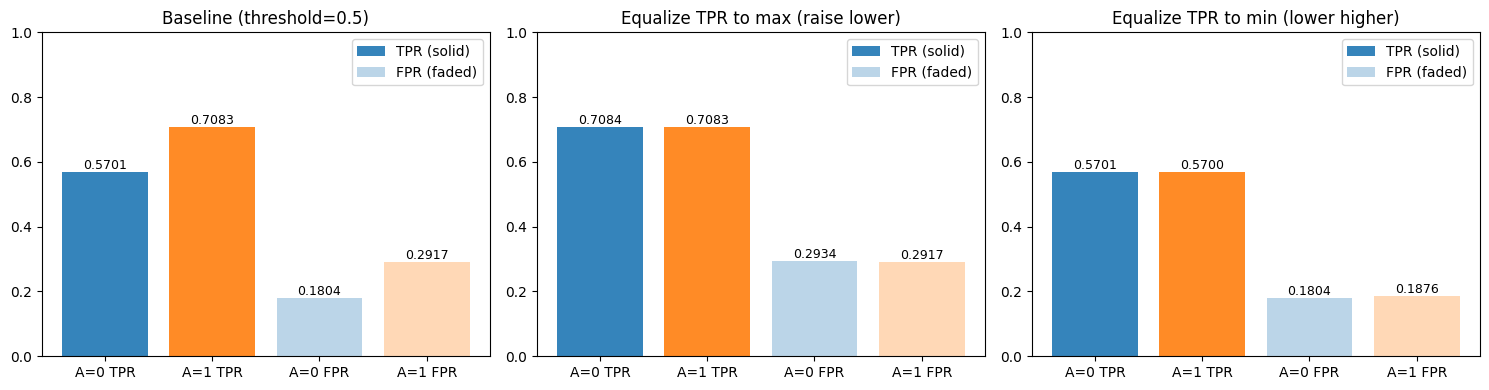

In [4]:
# Demo: Equalizing TPR across groups and observing effect on FPRs
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

np.random.seed(0)

# Try load real dataset (if local copy available), else create synthetic
try:
    import os
    local_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    if os.path.exists(local_path):
        dataset = pd.read_excel(local_path, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
        X = dataset.drop(columns=['SEX', 'default payment next month']).values
        A = dataset['SEX'].values
        y = dataset['default payment next month'].values
    else:
        raise FileNotFoundError
except Exception:
    # Synthetic dataset
    n = 10000
    A = np.random.binomial(1, 0.5, size=n)
    X1 = np.random.normal(0, 1, size=n)
    X2 = np.random.normal(0, 1, size=n) + 0.5 * A
    X = np.vstack([X1, X2]).T
    logits = -0.5 + 0.8 * X1 + 1.0 * X2
    probs = 1 / (1 + np.exp(-logits))
    y = (np.random.rand(n) < probs).astype(int)

# Split, train
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.5, random_state=1, stratify=A)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
probs_test = clf.predict_proba(X_test)[:,1]

# Helpers
def group_rates(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return tpr, fpr

def rates_by_group(y_true, probs, A, threshold=0.5):
    df = pd.DataFrame({"y": y_true, "p": probs, "A": A})
    out = {}
    for a, grp in df.groupby("A"):
        yhat = (grp["p"] >= threshold).astype(int)
        tpr, fpr = group_rates(grp["y"], yhat)
        out[a] = {"tpr": tpr, "fpr": fpr, "count": len(grp), "threshold": threshold}
    return pd.DataFrame(out).T

# Baseline at 0.5
baseline = rates_by_group(y_test, probs_test, A_test, threshold=0.5)
print("Baseline group rates (threshold=0.5):\n", baseline[['tpr','fpr']])

# find per-group threshold that best matches a target TPR (closest)
def threshold_for_target_tpr(y_true, probs, target_tpr):
    df = pd.DataFrame({"y": y_true, "p": probs}).sort_values("p", ascending=False)
    thresholds = np.unique(df["p"])
    best_t, best_diff, best_tpr = thresholds[0], 1.0, 0.0
    for t in thresholds:
        yhat = (df["p"] >= t).astype(int)
        tp = ((yhat==1) & (df["y"]==1)).sum()
        fn = ((yhat==0) & (df["y"]==1)).sum()
        tpr = tp / (tp+fn) if (tp+fn)>0 else 0.0
        diff = abs(tpr - target_tpr)
        if diff < best_diff:
            best_diff, best_t, best_tpr = diff, t, tpr
    return best_t, best_tpr

# target = max group TPR (raise the lower)
group_info = pd.DataFrame({"probs": probs_test, "y": y_test, "A": A_test})
group_tprs = {a: group_rates(grp["y"], (grp["probs"]>=0.5).astype(int))[0] for a, grp in group_info.groupby("A")}
print("Group TPRs at 0.5:", group_tprs)
target_tpr = max(group_tprs.values())

thresholds = {}
for a, grp in group_info.groupby("A"):
    t, achieved_tpr = threshold_for_target_tpr(grp["y"], grp["probs"], target_tpr)
    thresholds[a] = t

df = group_info.copy()
df['yhat_adj'] = 0
for a in df['A'].unique():
    df.loc[df['A']==a, 'yhat_adj'] = (df.loc[df['A']==a, 'probs'] >= thresholds[a]).astype(int)

rates_adj = {a: dict(zip(['tpr','fpr'], group_rates(grp['y'], grp['yhat_adj']))) 
             for a, grp in df.groupby('A')}
print("\nRates after equalizing TPR (raised to max):\n", pd.DataFrame(rates_adj).T)

# alternative: equalize down to min
target_tpr_min = min(group_tprs.values())
thresholds_min = {}
for a, grp in group_info.groupby("A"):
    t, achieved_tpr = threshold_for_target_tpr(grp["y"], grp["probs"], target_tpr_min)
    thresholds_min[a] = t

df2 = group_info.copy()
df2['yhat_adj'] = 0
for a in df2['A'].unique():
    df2.loc[df2['A']==a, 'yhat_adj'] = (df2.loc[df2['A']==a, 'probs'] >= thresholds_min[a]).astype(int)

rates_adj_min = {a: dict(zip(['tpr','fpr'], group_rates(grp['y'], grp['yhat_adj']))) 
                 for a, grp in df2.groupby('A')}
print("\nRates after equalizing TPR (lowered to min):\n", pd.DataFrame(rates_adj_min).T)

# Plot summary (TPR vs FPR)
baseline_vals = baseline[['tpr','fpr']].values
adj_vals = pd.DataFrame(rates_adj).T[['tpr','fpr']].values
adj_min_vals = pd.DataFrame(rates_adj_min).T[['tpr','fpr']].values

fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].bar(['A=0 TPR','A=1 TPR'], baseline_vals[:,0], color=['C0','C1'], alpha=0.9)
axes[0].bar(['A=0 FPR','A=1 FPR'], baseline_vals[:,1], color=['C0','C1'], alpha=0.3)
axes[0].set_title("Baseline (threshold=0.5)"); axes[0].set_ylim(0,1)

axes[1].bar(['A=0 TPR','A=1 TPR'], adj_vals[:,0], color=['C0','C1'], alpha=0.9)
axes[1].bar(['A=0 FPR','A=1 FPR'], adj_vals[:,1], color=['C0','C1'], alpha=0.3)
axes[1].set_title("Equalize TPR to max (raise lower)"); axes[1].set_ylim(0,1)

axes[2].bar(['A=0 TPR','A=1 TPR'], adj_min_vals[:,0], color=['C0','C1'], alpha=0.9)
axes[2].bar(['A=0 FPR','A=1 FPR'], adj_min_vals[:,1], color=['C0','C1'], alpha=0.3)
axes[2].set_title("Equalize TPR to min (lower higher)"); axes[2].set_ylim(0,1)
# Add value annotations on each bar

    

for ax in axes:
    ax.legend(['TPR (solid)','FPR (faded)'])
    for p in ax.patches:
        value = f"{p.get_height():.4f}"
        ax.annotate(value,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=9, color='black', rotation=0)

    
plt.tight_layout()
plt.show()


Equalizing TPR requires changing decision thresholds by group. To increase TPR for a group you lower that group’s threshold (label more individuals positive); to decrease TPR you raise the threshold (label fewer positive). 

Lowering the threshold increases both TP and FP, so when you raise a group’s TPR, you typically increase that group’s FPR as well. 

Conversely, lowering a group’s TPR will usually decrease that group’s FPR.

You can’t equalize everything at once, this is the classic trade-off: making one type of error more equal across groups often shifts inequality into other types of error. In practice, choosing which metric to equalize depends on context (e.g., do you care more about denying good applicants (lower FP) or extending credit to actual defaulters (lower FN, higher TP)).

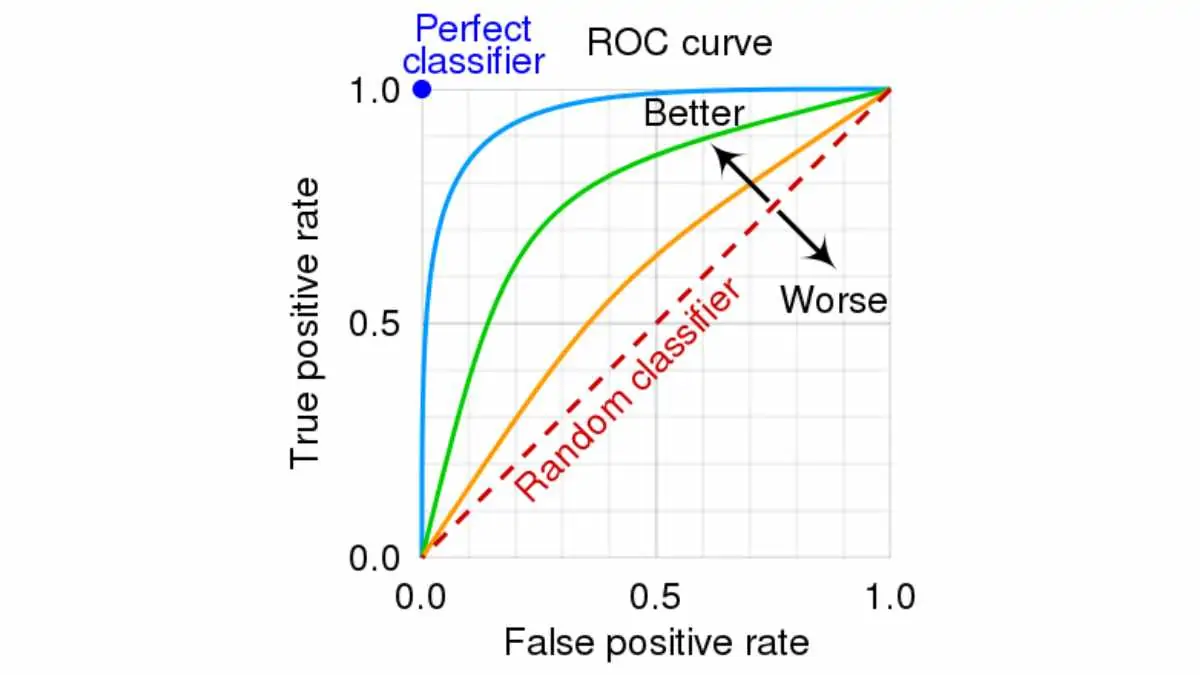

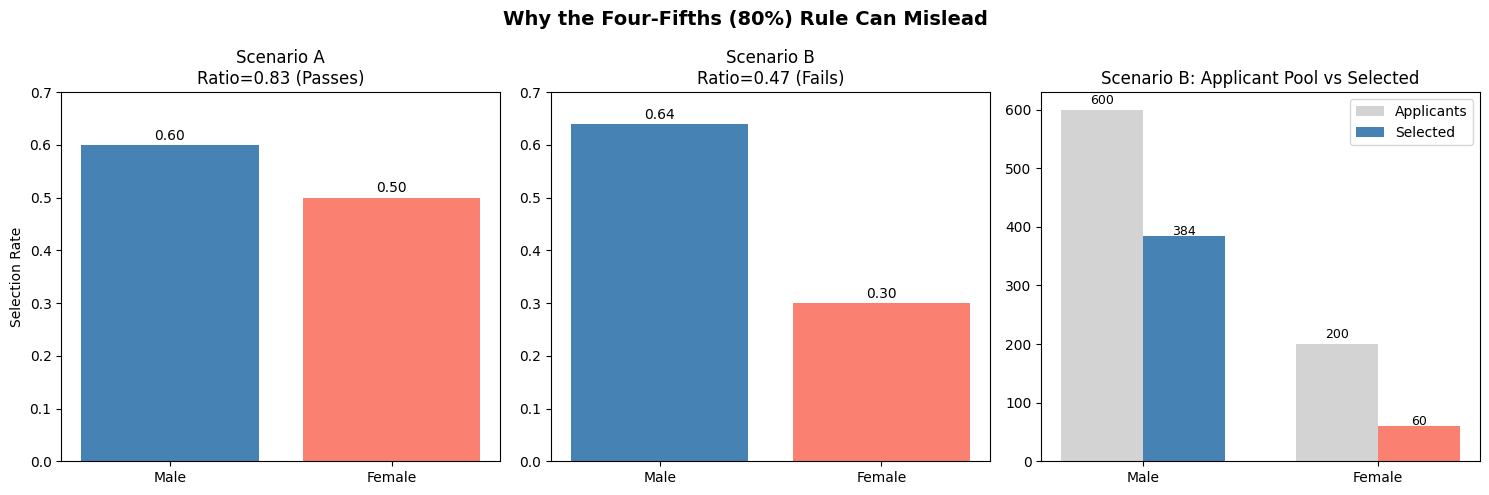

In [5]:
import matplotlib.pyplot as plt

# Scenario A: Passes 80% rule but still unfair
rates_A = {"Male": 0.60, "Female": 0.50}
ratio_A = rates_A["Female"] / rates_A["Male"]

# Scenario B: Fails 80% rule but not necessarily unfair
rates_B = {"Male": 0.64, "Female": 0.30}
ratio_B = rates_B["Female"] / rates_B["Male"]

# Applicant pool distribution for Scenario B
applicants_B = {"Male": 600, "Female": 200}   # example counts
selected_B = {g: applicants_B[g] * rate for g, rate in rates_B.items()}

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Why the Four-Fifths (80%) Rule Can Mislead", fontsize=14, weight="bold")

# --- Scenario A ---
axes[0].bar(rates_A.keys(), rates_A.values(), color=["steelblue", "salmon"])
for i, (group, rate) in enumerate(rates_A.items()):
    axes[0].text(i, rate+0.01, f"{rate:.2f}", ha="center", fontsize=10)
axes[0].set_title(f"Scenario A\nRatio={ratio_A:.2f} (Passes)")
axes[0].set_ylim(0, 0.7)
axes[0].set_ylabel("Selection Rate")

# --- Scenario B selection rates ---
axes[1].bar(rates_B.keys(), rates_B.values(), color=["steelblue", "salmon"])
for i, (group, rate) in enumerate(rates_B.items()):
    axes[1].text(i, rate+0.01, f"{rate:.2f}", ha="center", fontsize=10)
axes[1].set_title(f"Scenario B\nRatio={ratio_B:.2f} (Fails)")
axes[1].set_ylim(0, 0.7)

# --- Scenario B applicant pool ---
bar_width = 0.35
x = range(len(applicants_B))

axes[2].bar([i - bar_width/2 for i in x], applicants_B.values(), 
            width=bar_width, label="Applicants", color="lightgray")
axes[2].bar([i + bar_width/2 for i in x], selected_B.values(), 
            width=bar_width, label="Selected", color=["steelblue", "salmon"])
for i, (group, count) in enumerate(applicants_B.items()):
    axes[2].text(i - bar_width/2, count+10, str(count), ha="center", fontsize=9)
for i, (group, count) in enumerate(selected_B.items()):
    axes[2].text(i + bar_width/2, count+2, str(int(count)), ha="center", fontsize=9)
axes[2].set_xticks(x)
axes[2].set_xticklabels(applicants_B.keys())
axes[2].set_title("Scenario B: Applicant Pool vs Selected")
axes[2].legend()

plt.tight_layout()
plt.show()


Scenario A: Ratio > 0.8 (so it "passes"), but men have a systematically higher chance. Passing doesn’t mean “fair.” The rule does not see the absolute difference or individual-level fairness

Scenario B: Ratio < 0.8 (so it "fails"), but both groups are treated by the model equally (the model just set a threshold as 90, which is equal to two groups), But since the average female score is lower (maybe because fewer women applied with high qualifications), the selection rate for women is lower. Not the model applying a lower threshold for women, the model is using the same threshold. Disparity comes from different applicant base sizes, not model bias. Men dominate the pool (600 vs 200 applicants). 

In [6]:


np.random.seed(0)

# Male applicants: 600, average score 92, std 5
male_scores = np.random.normal(loc=92, scale=5, size=600)

# Female applicants: 200, average score 88, std 5
female_scores = np.random.normal(loc=88, scale=5, size=200)

# Selection threshold
threshold = 90

selected_males = male_scores[male_scores >= threshold]
selected_females = female_scores[female_scores >= threshold]

print("Male selection rate:", len(selected_males)/len(male_scores))
print("Female selection rate:", len(selected_females)/len(female_scores))


Male selection rate: 0.6366666666666667
Female selection rate: 0.295


### Introduce a Synthetic Feature

We are now going to manipulate the balance-limit feature `LIMIT_BAL` to make it highly predictive for the "female" group but not for the "male" group. Specifically, we set this up, so that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default. This might happen in reality if one of the groups has higher sources of income, such that the credit limit does not need to be exhausted or other sources of income allow to pay larger credit amounts. We're selecting gender as the protected attribute and "credit limit" as the feature that is predictive only for one of the groups, but the analysis could be generalized to other protected group definitions and predictive features.

After the transformation, `LIMIT_BAL` will be an arbitrary feature that, for one group (female), is associated with default. It is uninformative for the male clients.

Note that we are not implying that one of the groups is more likely to default than the other, as the Figures and metrics below will reveal. We simply assume that one group has a feature that is highly predictive.  

In [7]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})

# Extract the target
Y = dataset["default payment next month"]

categorical_features = ['EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

In [8]:
# dist_scale (standard deviation in a normal distribution) controls the extent to which 
# 'LIMIT_BAL' will correlated with Y, for the female group

# lower values of dist_scale imply a stronger correlation
dist_scale = 0.5
np.random.seed(12345)

# Make 'LIMIT_BAL' informative of the target (i.e., apply to all groups)
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])

# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

In the following plots we will visualize the distribution of feature 'LIMIT_BAL' in the four populations (Male-Default, Male-Non-Default, Female-Default and Female-Non-Default). 

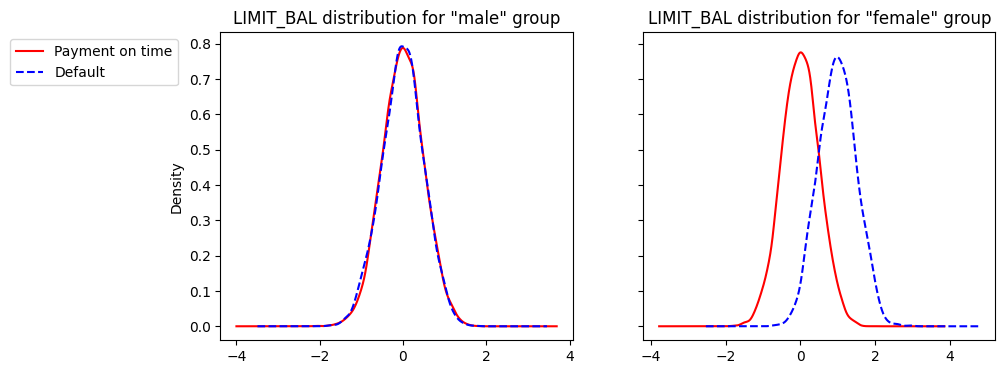

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)


# Plot distribution of LIMIT_BAL for men that default (orange, full line) and those that do not (blue, dashed)
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax1, 
                                           title="LIMIT_BAL distribution for \"male\" group", style='r-')

dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Default", ax=ax1, style='b--')


# Plot distribution of LIMIT_BAL for women that default (orange, full line) and those that do not (blue, dashed)
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for \"female\" group", style='r-')

dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Default", ax=ax2, 
                                           legend=True, style='b--').legend(bbox_to_anchor=(-1.3, 1))

plt.show()

**Q1: Lets refresh your Pandas indexing skills: can you calculate the fraction of male and female customers that default? Which group has a higher probability of default?**

In [11]:
# proportion per gender that default
sex_map = {1: 'male', 2: 'female'}
rates = dataset.groupby('SEX')['default payment next month'].mean().rename('default_rate')
rates.index = rates.index.map(sex_map)

print("Default rate by sex:")
print((rates * 100).round(2).astype(str) + "%")
print("Higher probability of default:", rates.idxmax())


Default rate by sex:
SEX
male      24.17%
female    20.78%
Name: default_rate, dtype: object
Higher probability of default: male


**Q2: Can you understand why the new `LIMIT_BAL` feature is indeed highly predictive for the "female" group, but not for the "male" group? Does that imply that one of the groups is more likely to default? Observe the figures above to inspire your questions**

Due to nosie added to Y+noise in females and Y in noise independent for males.

You should see AUC ≈ 0.5 for males (no signal) and > 0.5 for females (predictive), while base default rates can be similar.

Now we will apply the Scikit-learn Estimator API, as we discussed in previous Labs (see Lab 3), to fit a Decision Tree that learns to classify individuals into classes Default and Non-Default. 

To review materials related with Decision Trees plase check Lecture 7 slides, Chapter 8.1 of the [ISLR book](https://www.statlearning.com) and Chapter *In-Depth: Decision Trees and Random Forests* of the [PDSH book](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html). 

**Q3: Can you complete, below, the missing line to use a Decision Tree with maximum depth of 2?**

In [13]:
# 1. Import model

from sklearn.tree import DecisionTreeClassifier

# 2. Choose model hyperparameters

# MISSING LINE,
clf = DecisionTreeClassifier(random_state=1)

# 3. Arrange data into a fetures matrix and target vector; split data in train and test set
# As we are not tuning hyperparameters, for now it suffices to slit data in train and test (and skip validate)

df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

# 4. Fit model to data
decision_tree = clf.fit(df_train, Y_train)
df_train

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
17240,-0.242360,3,1,34,1,2,0,0,0,0,...,68034,68602,30252,47363,0,3000,3000,1508,20000,2500
13577,1.012592,1,1,46,-1,-1,2,2,-2,-2,...,2274,0,0,0,2462,0,0,0,0,0
4409,0.046682,2,1,50,1,-1,-1,-1,-1,0,...,2197,3047,4262,7163,5000,2200,6050,5000,3000,2000
28977,-0.687749,1,1,44,1,-1,-1,-1,-1,-1,...,595,1810,737,2555,2460,595,1815,737,2555,4290
26833,-0.115715,1,2,33,0,0,0,0,-2,-1,...,31023,-2639,-2787,34732,5000,14016,0,2000,38000,6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18194,-0.297570,3,2,38,0,0,0,0,0,0,...,290124,281667,289459,262269,15000,11000,10013,20000,30000,30000
28812,-0.270711,2,2,37,0,0,0,0,0,0,...,17709,18801,20328,25065,1800,1608,1700,2500,5065,1500
3826,0.530235,3,1,38,-2,-2,-1,-1,0,0,...,188,6498,44938,56015,0,188,6498,40000,12000,2500
11283,-0.708637,2,2,25,1,2,2,2,2,2,...,27915,27185,28806,28208,1600,1200,0,2200,0,2500


Index(['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


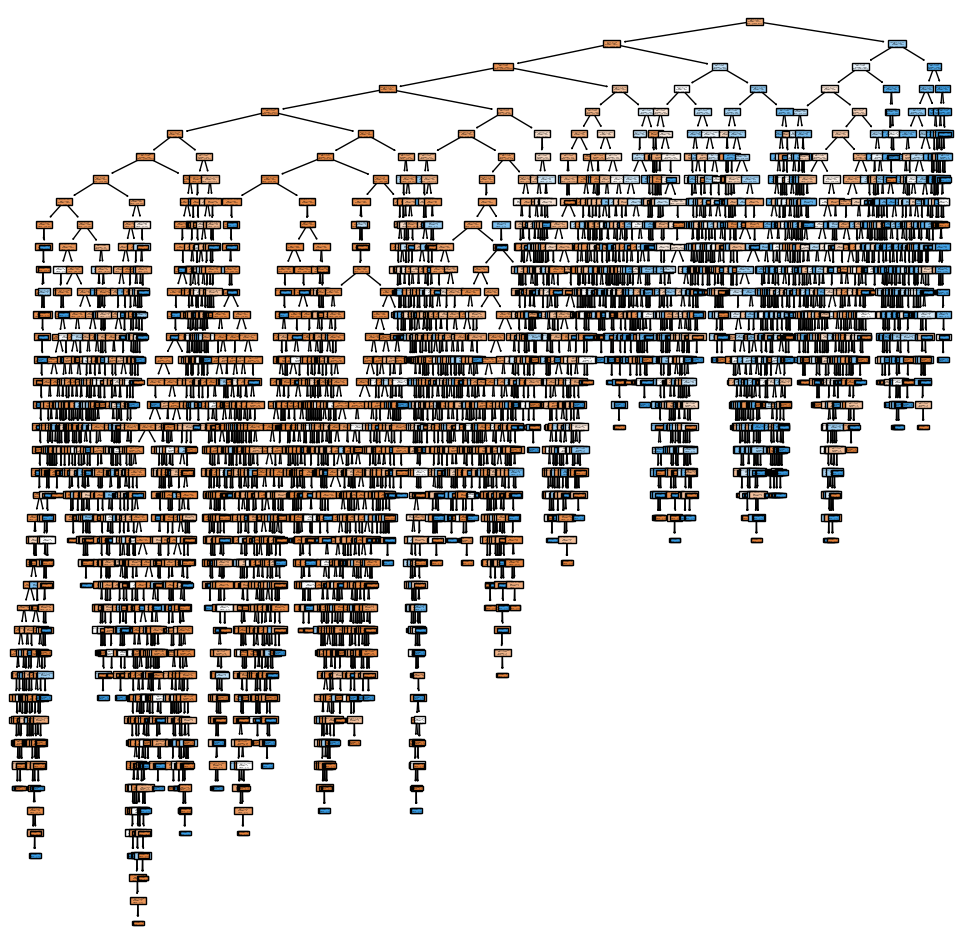

In [14]:
from sklearn.tree import plot_tree

print(dataset.drop(columns=['SEX', 'default payment next month']).columns)

plt.figure(figsize=(12,12))
plot_tree(decision_tree, filled=True, feature_names=dataset.drop(columns=['SEX', 'default payment next month']).columns)
plt.show()

**Q4: What is the meaning of *gini*, *samples* and *value* in the plot above?**

gini: Node impurity = 1 − Σ_k p_k^2, where p_k is the fraction of class k among samples at the node. 0 means pure; for binary, max is 0.5 at a 50/50 mix.

samples: Number of training samples that reached this node (after preceding splits). If sample_weight was used, this can reflect weighted counts.

value: Class counts at the node (one count per class, or weighted counts). The predicted class at the node is the class with the largest count.

We notice that the synthetic feature `LIMIT_BAL` appears as the most important feature in this model although it has no predictive power for an entire demographic segment in the data. We can observe this by plotting the Decision Tree we trained. Notice `LIMIT_BAL`  in the root of our tree. 

Below we use the trained Decision Tree to classify the test set (df_test). 
This is used to computer the accuracy of the model

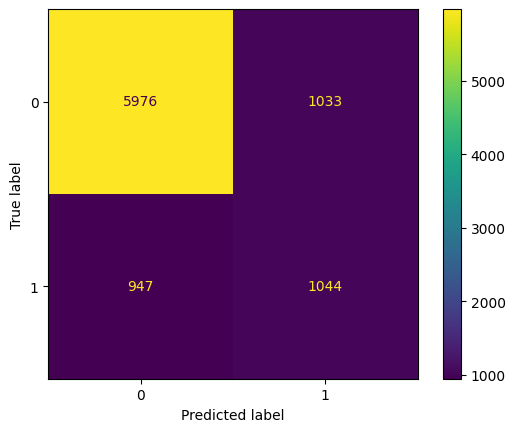

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 5. Predict labels for unknown data and evaluate
y_pred = clf.predict(df_test)

cm = confusion_matrix(Y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

**Q5: Compute the Sensitivity (or True Positive Rate), Specificity (or True Negative Rate), False Positive Rate, False Negative Rate and Precision for the previous confusion matrix.**

*Tip: Note that (1-Specificity) is also known as the False Positive Rate and (1-Sensitivity) the False Negative Rate.*

*Note: Being able to computer these metrics is highy relevant in the context of Quiz 3*

In [20]:
# Scores on test set
test_scores = clf.predict_proba(df_test)[:, 1]

# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

# Train AUC
roc_auc_score(Y_train, clf.predict_proba(df_train)[:, 1])

1.0

**Q6: What is the meaning of the value AUC above?**

Above, we computed Sensitivity (True Positive Rate) and Specificity (True Negative Rate) for the whole dataset, without distinguishing protected groups.

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (False Positive Rate and False Negative Rate) for different groups.

With `MetricFrame` (see [here](https://fairlearn.org/v0.5.0/api_reference/fairlearn.metrics.html) more details) we can easily compute the previous metrics independently for the two groups. That can be specified with option *sensitive_features*. Recall that <code>A_str_test</code> has info on who belongs to each group.

Note that both kinds of errors are more common in the "male" group than in the "female" group.

Note the difference in False Negative Rate we are obtaining for the two groups.

In [21]:
mf = MetricFrame(metrics={
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    y_true=Y_test, y_pred=y_pred, sensitive_features=A_str_test)

mf.by_group

,FPR,FNR
SEX,,
female,0.143315,0.352273
male,0.154108,0.642267


**Q7: Lets reflect on those values: we are classifying datapoints in Default (Positive) or Non-default (negative). The bank is likely to offer credit to individuals that are antecipated not to default (Negative). What does it mean that the female group has a lower FNR than the male group?**

**Q8: Can you say anything about Demographic Parity given the table above? What can you say about Equalized Odds?**

In [22]:
mf = MetricFrame(metrics={
    'Negative Rate (No Default)': selection_rate},
    y_true=Y_test, y_pred=y_pred, sensitive_features=A_str_test)

mf.by_group

,Negative Rate (No Default)
SEX,
female,0.248004
male,0.203555


**Q9: Can you say anything about Demographic Parity given the table above? What can you say about Equalized Odds?**

We now calculate several performance and fairness metrics below:

In [23]:
metrics_dict = {
        "Overall selection rate":  selection_rate(Y_test, y_pred, pos_label=0),
        "Demographic parity difference": demographic_parity_difference(Y_test, y_pred, sensitive_features=A_str_test),
        "Demographic parity ratio": demographic_parity_ratio(Y_test, y_pred, sensitive_features=A_str_test),
        "------": "",
        "False positive rate difference": false_positive_rate_difference(Y_test, y_pred, sensitive_features=A_str_test),
        "False negative rate difference": false_negative_rate_difference(Y_test, y_pred, sensitive_features=A_str_test),
        "Equalized odds difference": equalized_odds_difference(Y_test, y_pred, sensitive_features=A_str_test),
         "-------": "",
        "Overall AUC": roc_auc_score(Y_test, y_pred),
        "AUC difference": MetricFrame(metrics=roc_auc_score, y_true=Y_test, y_pred=y_pred, sensitive_features=A_str_test).difference(method='between_groups'),
    }

pd.DataFrame.from_dict(metrics_dict, orient="index", columns=["Metrics"])

,Metrics
Overall selection rate,0.769222
Demographic parity difference,0.044449
Demographic parity ratio,0.820772
------,
False positive rate difference,0.010793
False negative rate difference,0.289994
Equalized odds difference,0.289994
-------,
Overall AUC,0.688489
AUC difference,0.150394


As the overall performance metric we use the _area under ROC curve_ (AUC), which is suited to classification problems with a large imbalance between positive and negative examples.

As the fairness metric we use *equalized odds difference*, which quantifies the disparity in accuracy experienced by different demographics. Our goal is to assure that neither of the two groups ("male" vs "female") has substantially larger false-positive rates or false-negative rates than the other group. 

The table above shows the overall AUC of 0.75. There is a large disparity in we consider the equalized-odds difference.

**Q10: Why is the *equalized odds difference* the same as the *False negative rate difference*? Check the [Fairlearn documentation](https://fairlearn.org/v0.4.6/api_reference/fairlearn.metrics.html) to find an answer**

**Q11: Does the classifier satisfy Demographic Parity? Why? What would be necessary for a classifier to satisfy Demographic Parity?**

## Optional Material (Fairness)

Note: We are going to learn about methods to attenuate bias in supervised learning in Week 6 (Lecture 11). The example below will become clear after that lecture. No need to advance to this example in Lab 5 -- do it if you have spare time and are curious about how to tackle the biases identified above


## Mitigating Equalized Odds Difference with Postprocessing

We will now attempt to mitigate the disparities in our model using the Fairlearn postprocessing algorithm `ThresholdOptimizer`.

In Lecture 7 we discussed the idea that, depending on the problem we are facing, we can have different classification thresholds. The toy example provided was a poisonous mushroom classifier that classifies images in Positive (Poisonous) and Negative (Non-poisonous). We might want to play on the safe side and classify a mushroom as Positive if the probability of attributing class Poisonous is lower than 0.5.

We will now use the same idea (apply different classification threhsold) to correct the bias in our dataset.

This algorithm `ThresholdOptimizer` finds a suitable threshold for the scores (class probabilities) by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero.

In [24]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True,
    predict_method='predict')

NameError: name 'model' is not defined

In [ ]:
postprocess_est.fit(df_train, Y_train, sensitive_features=A_train)

In [ ]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [ ]:
metrics_dict = {
        "Overall selection rate":  selection_rate(Y_test, postprocess_preds, pos_label=0),
        "Demographic parity difference": demographic_parity_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
        "Demographic parity ratio": demographic_parity_ratio(Y_test, postprocess_preds, sensitive_features=A_str_test),
        "------": "",
        "False positive rate difference": false_positive_rate_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
        "False negative rate difference": false_negative_rate_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
        "Equalized odds difference": equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
         "-------": "",
        "Overall AUC": roc_auc_score(Y_test, postprocess_preds),
        "AUC difference": MetricFrame(metrics=roc_auc_score, y_true=Y_test, y_pred=postprocess_preds, sensitive_features=A_str_test).difference(method='between_groups'),
    }

pd.DataFrame.from_dict(metrics_dict, orient="index", columns=["Metrics"])

The ThresholdOptimizer algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off.

We explored how the `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 